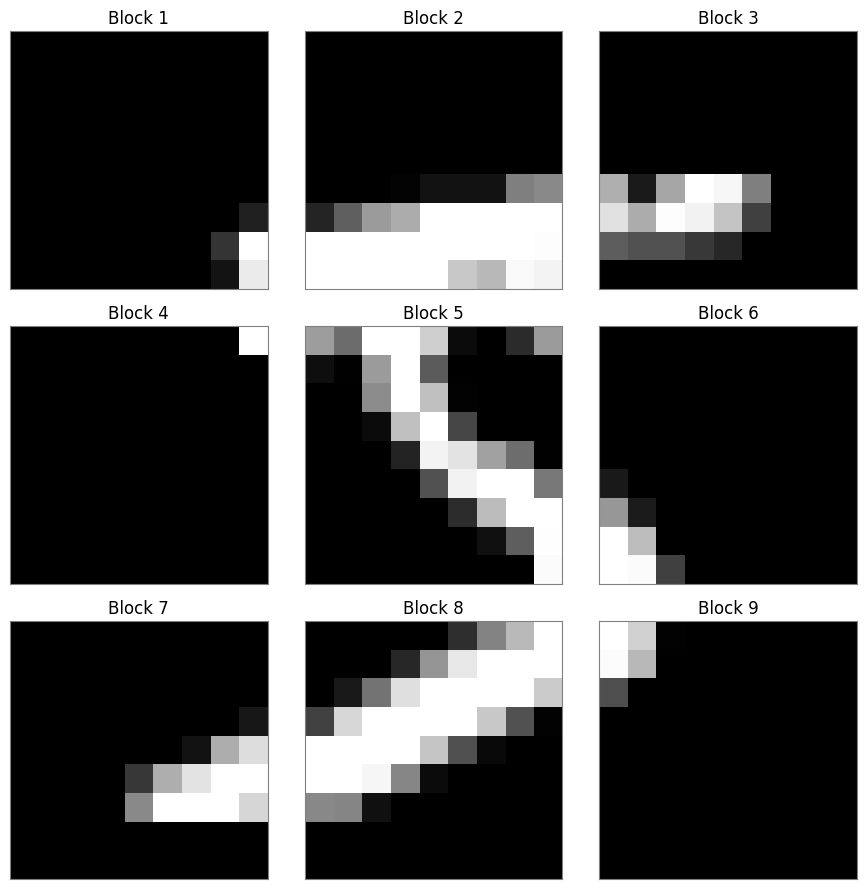

Accuracy: 0.8657619047619047


'\n# Train SVM classifier\nsvm_clf = SVC(kernel=\'linear\', C=1.0, random_state=42)\nsvm_clf.fit(X_train_features, y_train)\n\n# Predict on test data\nsvm_y_pred = svm_clf.predict(X_test_features)\n\n# Calculate accuracy\nsvm_accuracy = accuracy_score(y_test, svm_y_pred)\nprint("SVM Accuracy:", svm_accuracy)\n'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Binarize images
def binarize(image):
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_image

# Split image into 3x3 sub-images (blocks)
def split_image(image, num_blocks=9):
    sub_images = []
    h, w = image.shape
    block_h = h // 3
    block_w = w // 3
    for i in range(3):
        for j in range(3):
            block = image[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            sub_images.append(block)
    return sub_images

# Compute chain code from contour
def compute_chain_code(contour):
    chain_code = []

    # Define direction encoding (E=0, NE=1, N=2, NW=3, W=4, SW=5, S=6, NE=7)
    directions = {0: 0, 45: 1, 90: 2, 135: 3, 180: 4, 225: 5, 270: 6, 315: 7}

    # Check if the contour has at least two points
    if len(contour) < 2:
        return chain_code

    # Iterate over contour points
    for i in range(len(contour) - 1):
        # Compute the displacement vector between consecutive points
        dx = contour[i + 1][0][0] - contour[i][0][0]
        dy = contour[i + 1][0][1] - contour[i][0][1]

        # Compute the direction angle
        angle = np.arctan2(dy, dx) * 180 / np.pi

        # Normalize angle to [0, 360] degrees
        angle = (angle + 360) % 360

        # Round angle to the nearest multiple of 45 degrees
        nearest_angle = round(angle / 45) * 45

        # Map angle to direction encoding
        direction = directions[nearest_angle]
        chain_code.append(direction)

    return chain_code

# Extract contours from binarized image
def extract_contours(binarized_image):
    contours, _ = cv2.findContours(binarized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Extract chain codes from contours of sub-images
def extract_chain_codes(sub_images, max_length=100):
    chain_codes = []
    for sub_image in sub_images:
        # Extract contours from sub-image
        contours = extract_contours(sub_image)
        if len(contours) > 0:
            # Select the largest contour
            contour = max(contours, key=cv2.contourArea)
            # Compute chain code for the contour
            chain_code = compute_chain_code(contour)
            # Pad or truncate chain code to ensure consistent length
            if len(chain_code) < max_length:
                chain_code += [0] * (max_length - len(chain_code))  # Pad with zeros
            else:
                chain_code = chain_code[:max_length]  # Truncate
            # Append chain code to the list
            chain_codes.append(chain_code)
        else:
            # If no contour found, append zeros for padding
            chain_codes.append([0] * max_length)
    return chain_codes

# Extract features from images
def extract_features(images):
    features = []
    for image in images:
        # Binarize the image
        binary_image = binarize(image)
        # Split the binary image into sub-images
        sub_images = split_image(binary_image)
        # Extract chain codes from sub-images
        chain_codes = extract_chain_codes(sub_images)
        # Flatten the list of chain codes and append to features
        flattened_chain_codes = np.concatenate(chain_codes)
        features.append(flattened_chain_codes)
    return features

# Extract features from training and testing images
X_features = extract_features(np.concatenate((X_train, X_test)))
X_train_features, X_test_features, y_train, y_test = train_test_split(X_features, np.concatenate((y_train, y_test)), test_size=0.3, random_state=42)

# Visualize blocks of the first 2 images before applying the chain code
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 rows, 3 columns (for 9 blocks)
for idx, image in enumerate(X_train[:1]):
    # Calculate sub-images (blocks)
    sub_images = split_image(image)

    # Plot sub-images (blocks)
    for i, sub_image in enumerate(sub_images):
        row_index = i // 3
        col_index = i % 3
        axes[row_index, col_index].imshow(sub_image, cmap='gray', interpolation='nearest')
        axes[row_index, col_index].set_title(f'Block {i+1}')
        axes[row_index, col_index].axis('on')
        axes[row_index, col_index].set_xticks([])
        axes[row_index, col_index].set_yticks([])
        axes[row_index, col_index].set_xticklabels([])
        axes[row_index, col_index].set_yticklabels([])
        for spine in axes[row_index, col_index].spines.values():
            spine.set_visible(True)
            spine.set_color('gray')

plt.tight_layout()
plt.show()

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_features, y_train)

# Predict on test data
y_pred = clf.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.svm import SVC
"""
# Train SVM classifier
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf.fit(X_train_features, y_train)

# Predict on test data
svm_y_pred = svm_clf.predict(X_test_features)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print("SVM Accuracy:", svm_accuracy)
"""
